# Loading Data and Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [2]:
#Here we read all the files
df_users = pd.read_csv("users_v2.csv")
df_payments = pd.read_csv("payments_v2.csv")
df_payments_gateaways = pd.read_csv("payment_gateways_v2.csv")
df_engagment = pd.read_csv("engagement_v2.csv")

# Processing and cleaning Data for further analysis

A preliminary exploratory analysis was conducted on the tables where several issues of duplicates and nulls were found, which were subsequently addressed. Other points to consider are as follows:

1. There are null records in `user_id` and `email` fields, which are deleted as a match cannot be made.
2. Once all the dataframes were merged, we noticed duplicate records where some have `user_id` and others are null. To fix this missing data problem, we applied a loop that allows reassigning a value if the `user_id` was null and a match was found considering the other columns of `df_users`.
3. To fill in the missing `user_ids` that had an `email`, we took into account the values of `first_name` and `age`. If a `user_id` was found with these values, it was assigned (here we observed that in many cases, the only change was in the `is_working` column, which resulted in null)(Photo)


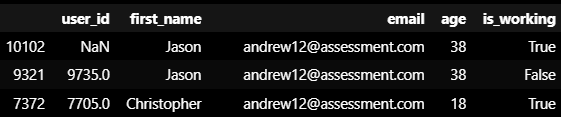


In [3]:
#After previous data analysis, we found duplicates in df_engagment and df_payments (exactly equals)
print(len(df_engagment.loc[df_engagment.duplicated(keep='first')]))
print(len(df_payments.loc[df_payments.duplicated(keep='first')]))

#We did this as we dont want to get duplicates when join with the df above, so we keep the last one as it was the last "login" or active user
print(len(df_users.loc[df_users.duplicated(subset=['user_id','email'],keep='last')]))

971
971
745


In [4]:
#Here we drop de duplicates found previously
df_engagment = df_engagment.drop_duplicates(keep='first').reset_index(drop=True)
df_payments = df_payments.drop_duplicates(keep='first').reset_index(drop=True)
df_users = df_users.drop_duplicates(subset=['user_id','email'],keep='last').reset_index(drop=True)

In [5]:
#First merge
df2 = df_engagment.merge(df_payments, how='inner', left_on=['subscription_id'], right_on=['subscription_id'])

#We delete here rows with null in user_id and email as it would be impossible to match it
df2 = df2.loc[~(df2.user_id.isna() & df2.email.isna())].reset_index(drop=True)

#Merge with df_users avoiding duplicates
df3 = df2.merge(df_users[~(df_users.user_id.isna() & df_users.email.isna())], how='inner', left_on=['user_id','email'], right_on=['user_id','email'])

#Finally merge with df_payments_gateaways
df4 = df3.merge(df_payments_gateaways, how='inner', left_on=['payment_gateway_id'], right_on=['payment_gateway_id'])

In [6]:
#Model to recover missing user_id based on all data in df_users to match it
cont=0
for i, values in df4.loc[(df4.user_id.isna()) & (~df4.email.isna()), ['subscription_id','email','first_name', 'age', 'is_working']].iterrows():
    df_aux = df_users.loc[(df_users.email == values[1]) & 
                       (df_users.first_name == values[2]) & 
                       (df_users.age == values[3]) & 
                       (df_users.is_working == values[4]) & 
                       (~df_users.user_id.isna())]
    if not df_aux.empty:
        df4.loc[i,["user_id"]] = df_aux.iloc[-1,0] #Here we take -1 for the logic of last register
        cont+=1
print(cont)        

182


In [7]:
#Model to recover missing user_id based in all data in df_users less if is_working
cont=0
for i, values in df4.loc[(df4.user_id.isna()) & (~df4.email.isna()), ['subscription_id','email','first_name', 'age']].iterrows():
    df_aux = df_users.loc[(df_users.email == values[1]) & 
                       (df_users.first_name == values[2]) & 
                       (df_users.age == values[3]) & 
                       (~df_users.user_id.isna())]
    if not df_aux.empty:
        df4.loc[i,["user_id"]] = df_aux.iloc[-1,0]
        cont+=1
print(cont)        

33


Finalmente, despues de todo el procesamiento, calculamos la cantidad de informacion perdida y vemos que es menor a 1%, por lo cual eliminamos los duplicaods para nuestro analisis

In [8]:
print("% of missing values to drop: ", 100*len(df4.loc[df4.user_id.isna()])/len(df4))

% of missing values to drop:  0.42854481088131174


In [9]:
df4 = df4.dropna(subset=['user_id'])

In [10]:
#convert date into datetime
df4['payment_date'] = pd.to_datetime(df4['payment_date'])
#the last log
df4['end_date'] = df4['payment_date'] + pd.to_timedelta(df4['active_days'], unit='D')

# Parte 1:

## Parte 1.1:  What was the Q1 2024 retention rate?

In [11]:
df_p1 = df4[['user_id', 'subscription_id', 'active_days','payment_date', 'subscription_number', 'end_date']].copy()

In [12]:
# Start and end dates of the first quarter of 2024
start_date = pd.Timestamp(2024, 1, 1)
end_date = pd.Timestamp(2024, 3, 31)

### Based on first subscription (new customers)
In this, we only view customers who bought his first time in this Q1

In [13]:
#Based on first subscription (new customers)
purchased_in_q1 = df_p1[(df_p1['payment_date'] >= start_date) & (df_p1['payment_date'] <= end_date) & (df_p1['subscription_number'] == 1)]
purchased_in_q1_users = purchased_in_q1['user_id'].unique()

activity_after_q1 = df_p1[df_p1['user_id'].isin(purchased_in_q1_users) & (df_p1['payment_date'] > end_date)]
retained_users_method_2 = activity_after_q1['user_id'].nunique()

print("Retention based on first subscription into Q1:", retained_users_method_2/len(purchased_in_q1_users))

Retention based on first subscription into Q1: 0.4304147465437788


### Based only in unique subscriptions into the Q
Here, we see all subscriptions in the Q despite of which discription number was

In [14]:
#Based only in unique subscriptions into the Q
purchased_in_q1 = df_p1[(df_p1['payment_date'] >= start_date) & (df_p1['payment_date'] <= end_date)]
purchased_in_q1_users = purchased_in_q1['user_id'].unique()

activity_after_q1 = df_p1[df_p1['user_id'].isin(purchased_in_q1_users) & (df_p1['payment_date'] > end_date)]
retained_users_method_2 = activity_after_q1['user_id'].nunique()

print("Retention based on subscription into Q1:", retained_users_method_2/len(purchased_in_q1_users))

Retention based on subscription into Q1: 0.476976114257572


### Based on subscriptions and clients that get through the activity of the Q
Here we take into account all flows in the Q, as they were customers that use the app thorugh their suscriptions on December

In [15]:
#Based on subscriptions and clients that get through the activity of the Q
purchased_in_q1 = df_p1[(df_p1['payment_date'] >= start_date) & (df_p1['payment_date'] <= end_date)]
active_in_q1 = df_p1[(df_p1['payment_date'] <= start_date) & (df_p1['end_date'] >= start_date)]

active_or_purchased_in_q1_users = set(purchased_in_q1['user_id'].unique().tolist() + active_in_q1['user_id'].unique().tolist())
activity_after_q1 = df_p1[df_p1['user_id'].isin(active_or_purchased_in_q1_users) & ((df_p1['payment_date'] > end_date) | (df_p1['end_date'] > end_date))]
retained_users_method_2 = activity_after_q1['user_id'].nunique()

print("Retention based on activity/resubscription into Q1:", retained_users_method_2/len(active_or_purchased_in_q1_users))

Retention based on activity/resubscription into Q1: 0.5066413662239089


Final results:

Retention based on first subscription into Q1: 42.74%

Retention based on subscription into Q1: 47.17%

Retention based on activity/resubscription into Q1: 50.14%


## Parte 1.2: Determine the number of subscribers in April 2024.

In [16]:
df_p2 = df4[['user_id', 'subscription_id','payment_date', 'subscription_number']].copy()

In [17]:
# April dates 2024
start_date = pd.Timestamp(2024, 4, 1)
end_date = pd.Timestamp(2024, 4, 30)

In [18]:
subscription_april = df_p1[(df_p2['payment_date'] >= start_date) & (df_p2['payment_date'] <= end_date)].user_id.nunique()

print("Total subscriptions in April 2024:", subscription_april)

subscription_april_first = df_p1[(df_p2['payment_date'] >= start_date) & (df_p2['payment_date'] <= end_date) & (df_p2["subscription_number"] == 1)].user_id.nunique()

print("Total first subscriptions in April 2024:", subscription_april_first)

Total subscriptions in April 2024: 2698
Total first subscriptions in April 2024: 761


**The total number of Subscriptions in April 2024 were 2698, however fist subscriptions were 761 which represents 28.20% of the total subscriptions**

# Parte 2: 

### 1. Develop strategies to improve user retention.

### 2. Perform a cohort analysis to assess churn risk for users renewing in May 2024.


## 2. Cohort Analysis

In [19]:
df_cohorts = df4[['user_id', 'subscription_id', 'active_days', 'courses_seen',
       'materials_seen', 'favorite_category','payment_date','age','is_working','subscription_number']].copy()

In [20]:
df_cohorts['payment_date'] = pd.to_datetime(df_cohorts['payment_date'])

In [21]:
df_cohorts['born_date'] = df_cohorts.groupby('user_id')['payment_date'].transform('min')

df_cohorts["payment_month"] = pd.to_datetime(df_cohorts["payment_date"].dt.strftime("%Y-%m"), format="%Y-%m")
df_cohorts["born_month"] = pd.to_datetime(df_cohorts["born_date"].dt.strftime("%Y-%m"), format="%Y-%m")

df_cohorts["months_alive"] = np.round((df_cohorts["payment_month"] - df_cohorts["born_month"]).dt.days/30)

In [22]:
def cohort_view(df_cohorts):
    # Grouping and aggregating the data
    grouped_df = df_cohorts.groupby(by=["months_alive", 'born_month']).agg({
        "user_id": pd.Series.nunique,
        "age": np.mean,
        "active_days": np.mean, 
        "courses_seen": np.mean, 
        'materials_seen': np.mean
    }).reset_index()

    first_users = df_cohorts.loc[(df_cohorts['months_alive'] == 0)].groupby('born_month')['user_id'].nunique().to_dict()

    # Calculating the percentage of users compared to the first cohort
    grouped_df = grouped_df.assign(user_percentage=lambda x: 100.00 * x.user_id / x.born_month.map(first_users))

    # Creating the pivot table
    pivoted_table_2 = pd.pivot_table(data=grouped_df, 
                                    columns=["months_alive"], 
                                    index=["born_month"], 
                                    values=["user_percentage", "user_id", "active_days", "courses_seen","materials_seen","age"], 
                                    aggfunc={"user_percentage": np.sum, "user_id": np.sum, "active_days": np.mean, "courses_seen": np.mean, "materials_seen": np.mean, "age": np.mean})

    # Filtering and cleaning the pivot table
    pivoted_table_2 = pivoted_table_2[pivoted_table_2.index >= df_cohorts["payment_month"].min()].dropna(axis=1, how="all").copy()

    # Renaming the index
    pivoted_table_2.index = [str(x.year) + "-" + str(x.month) for x in pivoted_table_2.index]
    return pivoted_table_2

In [23]:
pivoted_table_all = cohort_view(df_cohorts)

cm = sns.light_palette("orange", as_cmap=True)

# Set precision for numerical values
formatted_table = pivoted_table_all["user_id"].style.background_gradient(cmap=cm).format("{:.2f}")
# Display the formatted df
users_cohorts_percentaje = formatted_table.highlight_null('white')

# Set precision for numerical values
formatted_table = pivoted_table_all["user_percentage"].style.background_gradient(cmap=cm).format("{:.2f}")
# Display the formatted df
users_cohorts_absolut = formatted_table.highlight_null('white')

display(users_cohorts_absolut)
display(users_cohorts_percentaje)

months_alive,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000
2023-4,100.00,63.55,38.29,29.61,23.68,18.29,14.34,12.50,9.47,8.03,6.32,4.74
2023-5,100.00,64.57,39.71,31.15,23.66,18.45,14.44,11.23,9.49,7.35,4.68,3.61
2023-6,100.00,62.97,37.78,28.97,23.05,16.37,13.48,10.71,9.07,7.56,6.17,nan
2023-7,100.00,61.78,38.22,29.58,24.35,19.90,15.84,11.39,8.77,7.20,nan,nan
2023-8,100.00,59.63,38.52,30.87,24.41,20.18,14.64,12.14,10.16,nan,nan,nan
2023-9,100.00,63.23,39.20,28.47,22.46,19.60,15.16,12.73,nan,nan,nan,nan
2023-10,100.00,62.00,37.88,26.19,20.22,17.17,13.64,nan,nan,nan,nan,nan
2023-11,100.00,74.35,53.77,46.78,45.68,43.35,nan,nan,nan,nan,nan,nan
2023-12,100.00,70.01,49.69,41.41,34.88,nan,nan,nan,nan,nan,nan,nan
2024-1,100.00,63.14,40.82,30.78,nan,nan,nan,nan,nan,nan,nan,nan


months_alive,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000
2023-4,760.00,483.00,291.00,225.00,180.00,139.00,109.00,95.00,72.00,61.00,48.00,36.00
2023-5,748.00,483.00,297.00,233.00,177.00,138.00,108.00,84.00,71.00,55.00,35.00,27.00
2023-6,794.00,500.00,300.00,230.00,183.00,130.00,107.00,85.00,72.00,60.00,49.00,nan
2023-7,764.00,472.00,292.00,226.00,186.00,152.00,121.00,87.00,67.00,55.00,nan,nan
2023-8,758.00,452.00,292.00,234.00,185.00,153.00,111.00,92.00,77.00,nan,nan,nan
2023-9,699.00,442.00,274.00,199.00,157.00,137.00,106.00,89.00,nan,nan,nan,nan
2023-10,821.00,509.00,311.00,215.00,166.00,141.00,112.00,nan,nan,nan,nan,nan
2023-11,729.00,542.00,392.00,341.00,333.00,316.00,nan,nan,nan,nan,nan,nan
2023-12,797.00,558.00,396.00,330.00,278.00,nan,nan,nan,nan,nan,nan,nan
2024-1,757.00,478.00,309.00,233.00,nan,nan,nan,nan,nan,nan,nan,nan


In [24]:
for work in df_cohorts.is_working.unique():
    pivoted_table_all = cohort_view(df_cohorts.loc[df_cohorts.is_working==work])

    # Generate a random color
    random_color = np.random.rand(3,)

    # Create a colormap using the random color
    cm = sns.light_palette(random_color, as_cmap=True)
    
    # Set precision for numerical values
    formatted_table = pivoted_table_all["user_id"].style.background_gradient(cmap=cm).format("{:.2f}")
    # Display the formatted DataFrame
    users_cohorts_percentaje = formatted_table.highlight_null('white')

    # Set precision for numerical values
    formatted_table = pivoted_table_all["user_percentage"].style.background_gradient(cmap=cm).format("{:.2f}")
    # Display the formatted DataFrame
    users_cohorts_absolut = formatted_table.highlight_null('white')

    print(f"---------------- VIEW IS_WORKING {work} --------------------")
    display(users_cohorts_absolut)
    display(users_cohorts_percentaje)

---------------- VIEW IS_WORKING True --------------------


months_alive,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000
2023-4,100.00,68.78,43.88,35.31,30.82,25.92,22.24,19.39,14.69,12.45,9.80,7.35
2023-5,100.00,67.93,43.23,35.06,28.49,25.10,21.51,16.73,14.14,10.96,6.97,5.38
2023-6,100.00,64.67,39.19,32.82,27.80,22.59,20.66,16.41,13.90,11.58,9.46,nan
2023-7,100.00,67.58,44.01,35.56,30.84,26.72,23.77,17.09,13.16,10.81,nan,nan
2023-8,100.00,63.35,43.03,38.25,31.27,27.09,22.11,18.33,15.34,nan,nan,nan
2023-9,100.00,66.30,42.45,34.35,28.01,26.70,23.19,19.47,nan,nan,nan,nan
2023-10,100.00,66.10,43.63,31.46,25.09,23.97,20.97,nan,nan,nan,nan,nan
2023-11,100.00,74.60,54.73,47.34,45.73,44.34,nan,nan,nan,nan,nan,nan
2023-12,100.00,69.98,50.32,43.13,35.52,nan,nan,nan,nan,nan,nan,nan
2024-1,100.00,61.27,40.61,30.75,nan,nan,nan,nan,nan,nan,nan,nan


months_alive,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000
2023-4,490.00,337.00,215.00,173.00,151.00,127.00,109.00,95.00,72.00,61.00,48.00,36.00
2023-5,502.00,341.00,217.00,176.00,143.00,126.00,108.00,84.00,71.00,55.00,35.00,27.00
2023-6,518.00,335.00,203.00,170.00,144.00,117.00,107.00,85.00,72.00,60.00,49.00,nan
2023-7,509.00,344.00,224.00,181.00,157.00,136.00,121.00,87.00,67.00,55.00,nan,nan
2023-8,502.00,318.00,216.00,192.00,157.00,136.00,111.00,92.00,77.00,nan,nan,nan
2023-9,457.00,303.00,194.00,157.00,128.00,122.00,106.00,89.00,nan,nan,nan,nan
2023-10,534.00,353.00,233.00,168.00,134.00,128.00,112.00,nan,nan,nan,nan,nan
2023-11,433.00,323.00,237.00,205.00,198.00,192.00,nan,nan,nan,nan,nan,nan
2023-12,473.00,331.00,238.00,204.00,168.00,nan,nan,nan,nan,nan,nan,nan
2024-1,426.00,261.00,173.00,131.00,nan,nan,nan,nan,nan,nan,nan,nan


---------------- VIEW IS_WORKING False --------------------


months_alive,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000
2023-4,100.00,54.07,28.15,19.26,10.74,4.44
2023-5,100.00,57.72,32.52,23.17,13.82,4.88
2023-6,100.00,59.78,35.14,21.74,14.13,4.71
2023-7,100.00,50.20,26.67,17.65,11.37,6.27
2023-8,100.00,52.34,29.69,16.41,10.94,6.64
2023-9,100.00,57.44,33.06,17.36,11.98,6.20
2023-10,100.00,54.36,27.18,16.38,11.15,4.53
2023-11,100.00,73.99,52.36,45.95,45.61,41.89
2023-12,100.00,70.06,48.77,38.89,33.95,nan
2024-1,100.00,65.56,41.09,30.82,nan,nan


months_alive,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000
2023-4,270.00,146.00,76.00,52.00,29.00,12.00
2023-5,246.00,142.00,80.00,57.00,34.00,12.00
2023-6,276.00,165.00,97.00,60.00,39.00,13.00
2023-7,255.00,128.00,68.00,45.00,29.00,16.00
2023-8,256.00,134.00,76.00,42.00,28.00,17.00
2023-9,242.00,139.00,80.00,42.00,29.00,15.00
2023-10,287.00,156.00,78.00,47.00,32.00,13.00
2023-11,296.00,219.00,155.00,136.00,135.00,124.00
2023-12,324.00,227.00,158.00,126.00,110.00,nan
2024-1,331.00,217.00,136.00,102.00,nan,nan


In [25]:
for cat in df_cohorts.favorite_category.unique():
    if not pd.isna(cat):
        pivoted_table_all = cohort_view(df_cohorts.loc[df_cohorts.favorite_category==cat])

        # Generate a random color
        random_color = np.random.rand(3,)

        # Create a colormap using the random color
        cm = sns.light_palette(random_color, as_cmap=True)
        
        # Set precision for numerical values
        formatted_table = pivoted_table_all["user_id"].style.background_gradient(cmap=cm).format("{:.2f}")
        # Display the formatted DataFrame
        users_cohorts_percentaje = formatted_table.highlight_null('white')

        # Set precision for numerical values
        formatted_table = pivoted_table_all["user_percentage"].style.background_gradient(cmap=cm).format("{:.2f}")
        # Display the formatted DataFrame
        users_cohorts_absolut = formatted_table.highlight_null('white')

        print(f"---------------- VIEW FAV CATEGORY: {cat} --------------------")
        display(users_cohorts_absolut)
        display(users_cohorts_percentaje)

---------------- VIEW FAV CATEGORY: Marketing --------------------


months_alive,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000
2023-4,100.00,79.79,45.60,40.41,32.64,20.73,19.17,16.06,14.51,10.88,8.29,4.66
2023-5,100.00,83.52,46.02,46.59,27.84,28.98,19.89,12.50,12.50,9.66,7.95,4.55
2023-6,100.00,68.25,49.29,39.34,31.75,20.85,23.22,13.27,9.48,9.48,8.06,nan
2023-7,100.00,72.06,44.61,36.76,28.92,26.47,18.63,13.24,10.78,5.39,nan,nan
2023-8,100.00,78.97,49.74,42.56,29.74,25.13,21.54,21.54,12.82,nan,nan,nan
2023-9,100.00,93.14,53.14,40.57,26.29,31.43,17.71,20.00,nan,nan,nan,nan
2023-10,100.00,83.57,48.31,36.71,21.26,21.74,15.46,nan,nan,nan,nan,nan
2023-11,100.00,105.52,76.24,59.12,58.56,59.12,nan,nan,nan,nan,nan,nan
2023-12,100.00,84.62,58.65,52.40,44.71,nan,nan,nan,nan,nan,nan,nan
2024-1,100.00,85.03,57.75,47.59,nan,nan,nan,nan,nan,nan,nan,nan


months_alive,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000
2023-4,193.00,154.00,88.00,78.00,63.00,40.00,37.00,31.00,28.00,21.00,16.00,9.00
2023-5,176.00,147.00,81.00,82.00,49.00,51.00,35.00,22.00,22.00,17.00,14.00,8.00
2023-6,211.00,144.00,104.00,83.00,67.00,44.00,49.00,28.00,20.00,20.00,17.00,nan
2023-7,204.00,147.00,91.00,75.00,59.00,54.00,38.00,27.00,22.00,11.00,nan,nan
2023-8,195.00,154.00,97.00,83.00,58.00,49.00,42.00,42.00,25.00,nan,nan,nan
2023-9,175.00,163.00,93.00,71.00,46.00,55.00,31.00,35.00,nan,nan,nan,nan
2023-10,207.00,173.00,100.00,76.00,44.00,45.00,32.00,nan,nan,nan,nan,nan
2023-11,181.00,191.00,138.00,107.00,106.00,107.00,nan,nan,nan,nan,nan,nan
2023-12,208.00,176.00,122.00,109.00,93.00,nan,nan,nan,nan,nan,nan,nan
2024-1,187.00,159.00,108.00,89.00,nan,nan,nan,nan,nan,nan,nan,nan


---------------- VIEW FAV CATEGORY: Computer Science --------------------


months_alive,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000
2023-4,100.00,39.30,27.10,18.70,20.33,14.91,10.03,7.59,5.96,3.79,3.52,4.07
2023-5,100.00,46.46,30.05,19.70,17.42,11.87,9.34,10.10,4.55,4.80,1.77,2.02
2023-6,100.00,44.57,24.29,20.57,15.71,11.43,8.29,7.71,7.14,5.71,4.86,nan
2023-7,100.00,41.19,23.86,21.02,19.60,13.92,10.51,7.10,7.67,5.40,nan,nan
2023-8,100.00,46.59,28.69,19.60,17.33,16.48,9.66,9.38,5.97,nan,nan,nan
2023-9,100.00,39.77,29.82,20.47,14.62,10.53,12.28,7.31,nan,nan,nan,nan
2023-10,100.00,43.15,24.62,17.01,16.24,11.68,10.91,nan,nan,nan,nan,nan
2023-11,100.00,50.00,34.62,36.98,32.25,32.25,nan,nan,nan,nan,nan,nan
2023-12,100.00,50.41,34.42,30.08,24.39,nan,nan,nan,nan,nan,nan,nan
2024-1,100.00,43.05,24.33,17.38,nan,nan,nan,nan,nan,nan,nan,nan


months_alive,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000
2023-4,369.00,145.00,100.00,69.00,75.00,55.00,37.00,28.00,22.00,14.00,13.00,15.00
2023-5,396.00,184.00,119.00,78.00,69.00,47.00,37.00,40.00,18.00,19.00,7.00,8.00
2023-6,350.00,156.00,85.00,72.00,55.00,40.00,29.00,27.00,25.00,20.00,17.00,nan
2023-7,352.00,145.00,84.00,74.00,69.00,49.00,37.00,25.00,27.00,19.00,nan,nan
2023-8,352.00,164.00,101.00,69.00,61.00,58.00,34.00,33.00,21.00,nan,nan,nan
2023-9,342.00,136.00,102.00,70.00,50.00,36.00,42.00,25.00,nan,nan,nan,nan
2023-10,394.00,170.00,97.00,67.00,64.00,46.00,43.00,nan,nan,nan,nan,nan
2023-11,338.00,169.00,117.00,125.00,109.00,109.00,nan,nan,nan,nan,nan,nan
2023-12,369.00,186.00,127.00,111.00,90.00,nan,nan,nan,nan,nan,nan,nan
2024-1,374.00,161.00,91.00,65.00,nan,nan,nan,nan,nan,nan,nan,nan


---------------- VIEW FAV CATEGORY: English --------------------


months_alive,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000
2023-4,100.00,92.89,52.28,39.59,21.32,22.34,17.77,18.27,11.17,13.20,9.14,6.09
2023-5,100.00,86.86,54.86,41.14,33.71,22.86,20.57,12.57,17.71,10.86,7.43,6.29
2023-6,100.00,86.52,48.26,32.61,26.52,20.00,12.61,13.04,11.74,8.70,6.52,nan
2023-7,100.00,86.89,56.80,37.38,28.16,23.79,22.33,16.99,8.25,11.65,nan,nan
2023-8,100.00,63.81,44.76,39.05,31.43,21.90,16.19,8.10,14.76,nan,nan,nan
2023-9,100.00,79.01,43.09,32.04,33.70,25.41,18.23,16.02,nan,nan,nan,nan
2023-10,100.00,74.89,52.05,32.88,26.03,22.83,16.89,nan,nan,nan,nan,nan
2023-11,100.00,86.67,65.24,51.90,56.19,47.14,nan,nan,nan,nan,nan,nan
2023-12,100.00,89.04,67.12,50.23,42.47,nan,nan,nan,nan,nan,nan,nan
2024-1,100.00,81.03,56.41,40.00,nan,nan,nan,nan,nan,nan,nan,nan


months_alive,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000
2023-4,197.00,183.00,103.00,78.00,42.00,44.00,35.00,36.00,22.00,26.00,18.00,12.00
2023-5,175.00,152.00,96.00,72.00,59.00,40.00,36.00,22.00,31.00,19.00,13.00,11.00
2023-6,230.00,199.00,111.00,75.00,61.00,46.00,29.00,30.00,27.00,20.00,15.00,nan
2023-7,206.00,179.00,117.00,77.00,58.00,49.00,46.00,35.00,17.00,24.00,nan,nan
2023-8,210.00,134.00,94.00,82.00,66.00,46.00,34.00,17.00,31.00,nan,nan,nan
2023-9,181.00,143.00,78.00,58.00,61.00,46.00,33.00,29.00,nan,nan,nan,nan
2023-10,219.00,164.00,114.00,72.00,57.00,50.00,37.00,nan,nan,nan,nan,nan
2023-11,210.00,182.00,137.00,109.00,118.00,99.00,nan,nan,nan,nan,nan,nan
2023-12,219.00,195.00,147.00,110.00,93.00,nan,nan,nan,nan,nan,nan,nan
2024-1,195.00,158.00,110.00,78.00,nan,nan,nan,nan,nan,nan,nan,nan


### Cohort Analysis Insights

#### Working vs. Non-Working Cohorts
- Working individuals exhibit better cohort retention compared to non-working individuals.
- There's a potential need for boosting job opportunities and career growth among non-working cohorts to enhance their retention rates. This could alleviate the pressure of job hunting and income instability.

#### Category Analysis
- **Marketing**: Shows the highest retention rates among all categories.
- **English**: Exhibits strong short-term retention; however, retention declines after the first two months_alive. This could be attributed to platform content. 
- **Computing**: Demonstrates poor retention, suggesting that individuals might initially engage with the content but give up quickly, possibly due to the complexity of the subject matter.

#### Retention Trends
- After the first month, overall retention stands at approximately 60%.
- Retention steadily declines over time, dropping to around 10% by the eighth month_alive.

#### Why the Decline in Retention?
The significant decline in retention rates over time warrants further investigation. Possible factors contributing to this decline could include:
1. **Content Quality**: Diminishing interest due to repetitive or less engaging content.
2. **User Experience**: Issues with platform usability or accessibility.

Further analysis is required to pinpoint the exact reasons behind the decline in retention and to formulate strategies for retention improvement.

## 1. Strategies to improve user retention

### 1.1 Analysis of the data

Firstable we are going to analyse our data to find insights and possible oportunities of improvement (that is why we did first our chort analysis, to complement the strategies)

In [243]:
df4.describe()

,user_id,active_days,courses_seen,materials_seen,amount,payment_date,payment_gateway_id,subscription_number,age,end_date
count,26720.000000,26720.000000,26720.000000,26720.000000,26720.000000,26720,26720.000000,26720.000000,26720.000000,26720
mean,4987.645284,8.128518,1.627470,16.309019,79.501497,2023-11-15 02:53:22.275448832,3.274139,2.844237,30.172754,2023-11-23 05:58:26.227544832
min,1.000000,-1.000000,0.000000,0.000000,10.000000,2023-04-01 00:00:00,1.000000,1.000000,18.000000,2023-04-04 00:00:00
25%,2524.750000,5.000000,1.000000,10.000000,20.000000,2023-08-22 00:00:00,2.000000,1.000000,23.000000,2023-08-30 00:00:00
50%,4992.000000,8.000000,2.000000,15.000000,20.000000,2023-11-26 00:00:00,3.000000,2.000000,30.000000,2023-12-04 00:00:00
75%,7469.000000,10.000000,2.000000,23.000000,20.000000,2024-02-15 00:00:00,5.000000,4.000000,36.000000,2024-02-23 00:00:00
max,10000.000000,31.000000,6.000000,68.000000,540000.000000,2024-04-30 00:00:00,6.000000,12.000000,67.000000,2024-05-21 00:00:00
std,2870.946632,3.757073,0.796946,9.243963,4692.961618,NaN,1.730991,2.200831,8.836308,NaN


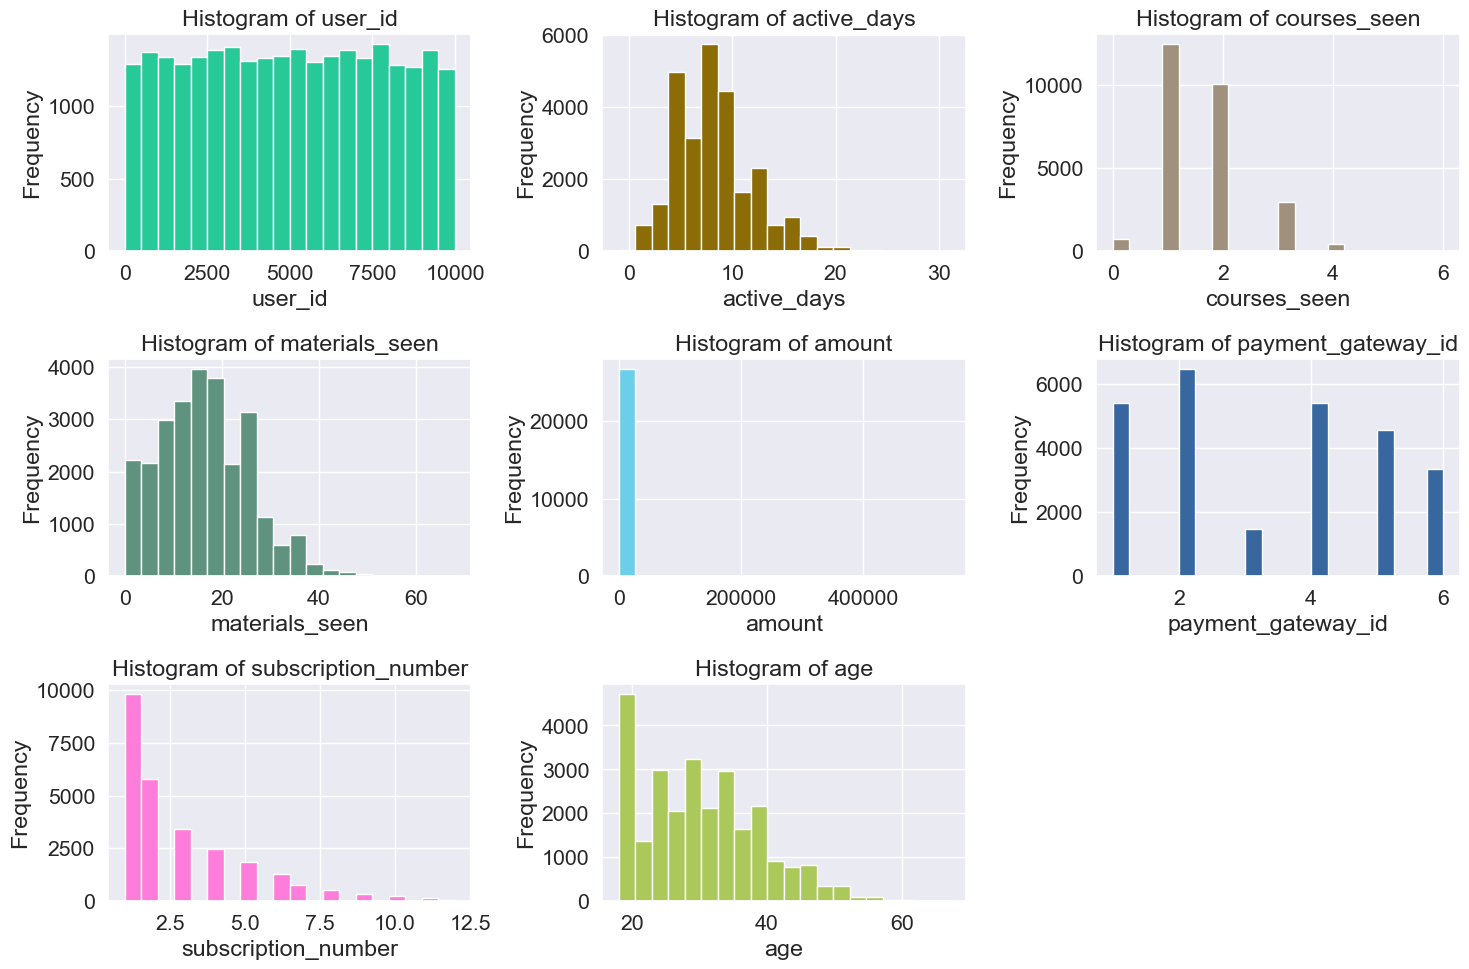

In [250]:
numerical_columns = df4.select_dtypes(include=['int64', 'float64']).columns

# Calculate number of rows and columns for subplots
num_cols = 3
num_rows = (len(numerical_columns) - 1) // num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()

# Iterate over numerical columns
for i, column in enumerate(numerical_columns):
    color = np.random.rand(3,)
    # Plot histogram
    df4[column].hist(bins=20, ax=axes[i], color=color)
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(len(numerical_columns), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


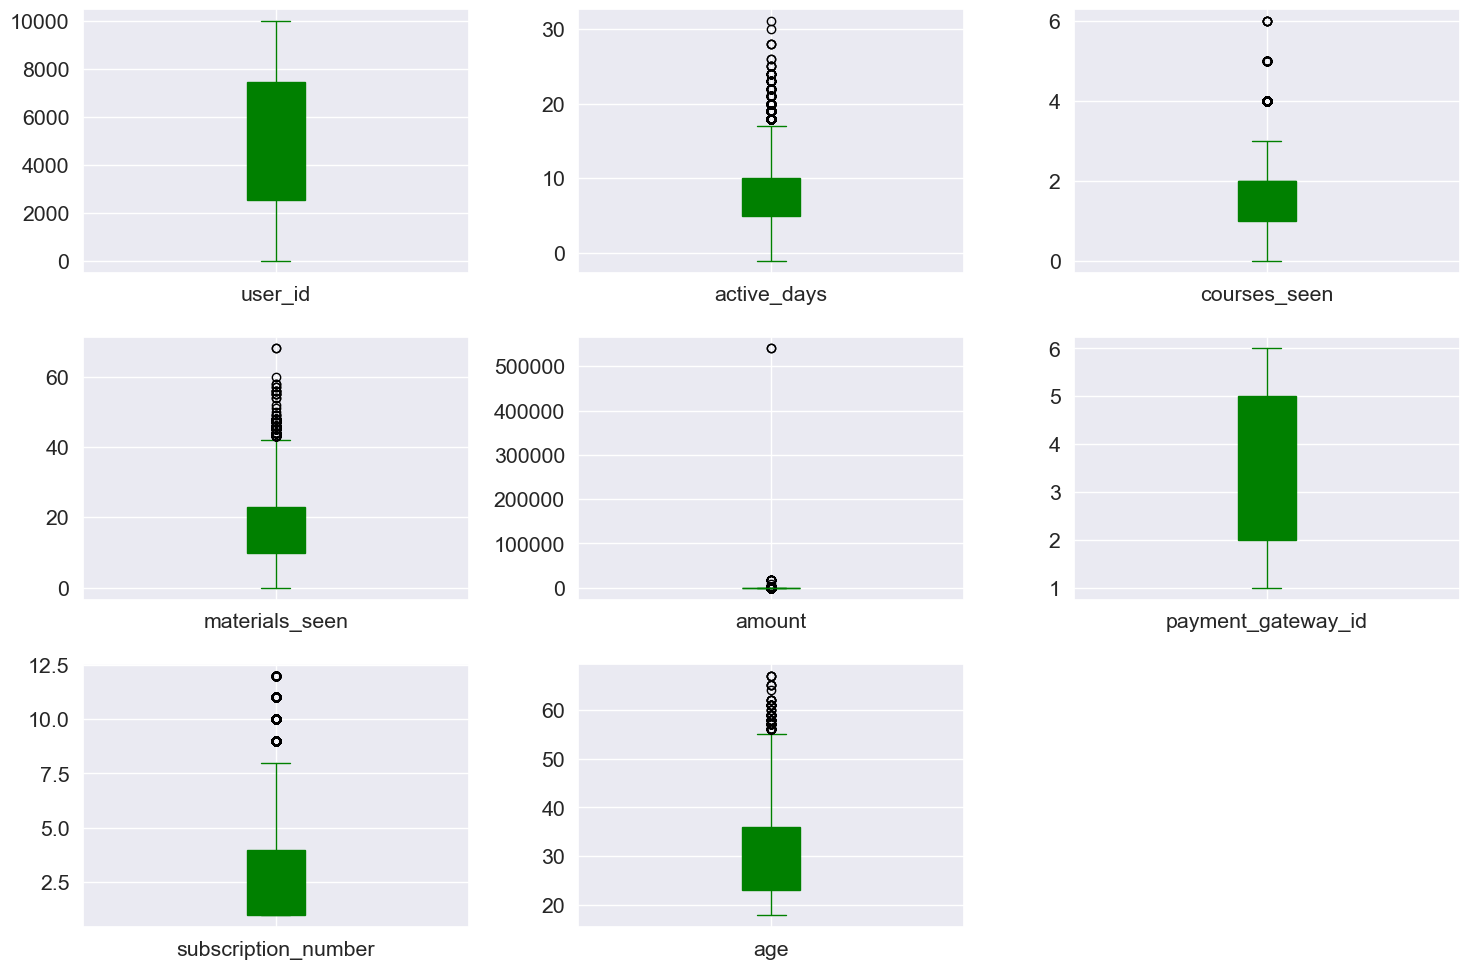

In [260]:
# Create subplots for boxplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()

# Iterate over numerical columns
for i, column in enumerate(numerical_columns):
    # Plot boxplot
    bp = df4.boxplot(column=column, ax=axes[i], patch_artist=True,color="green")

# Hide unused subplots
for j in range(len(numerical_columns), len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


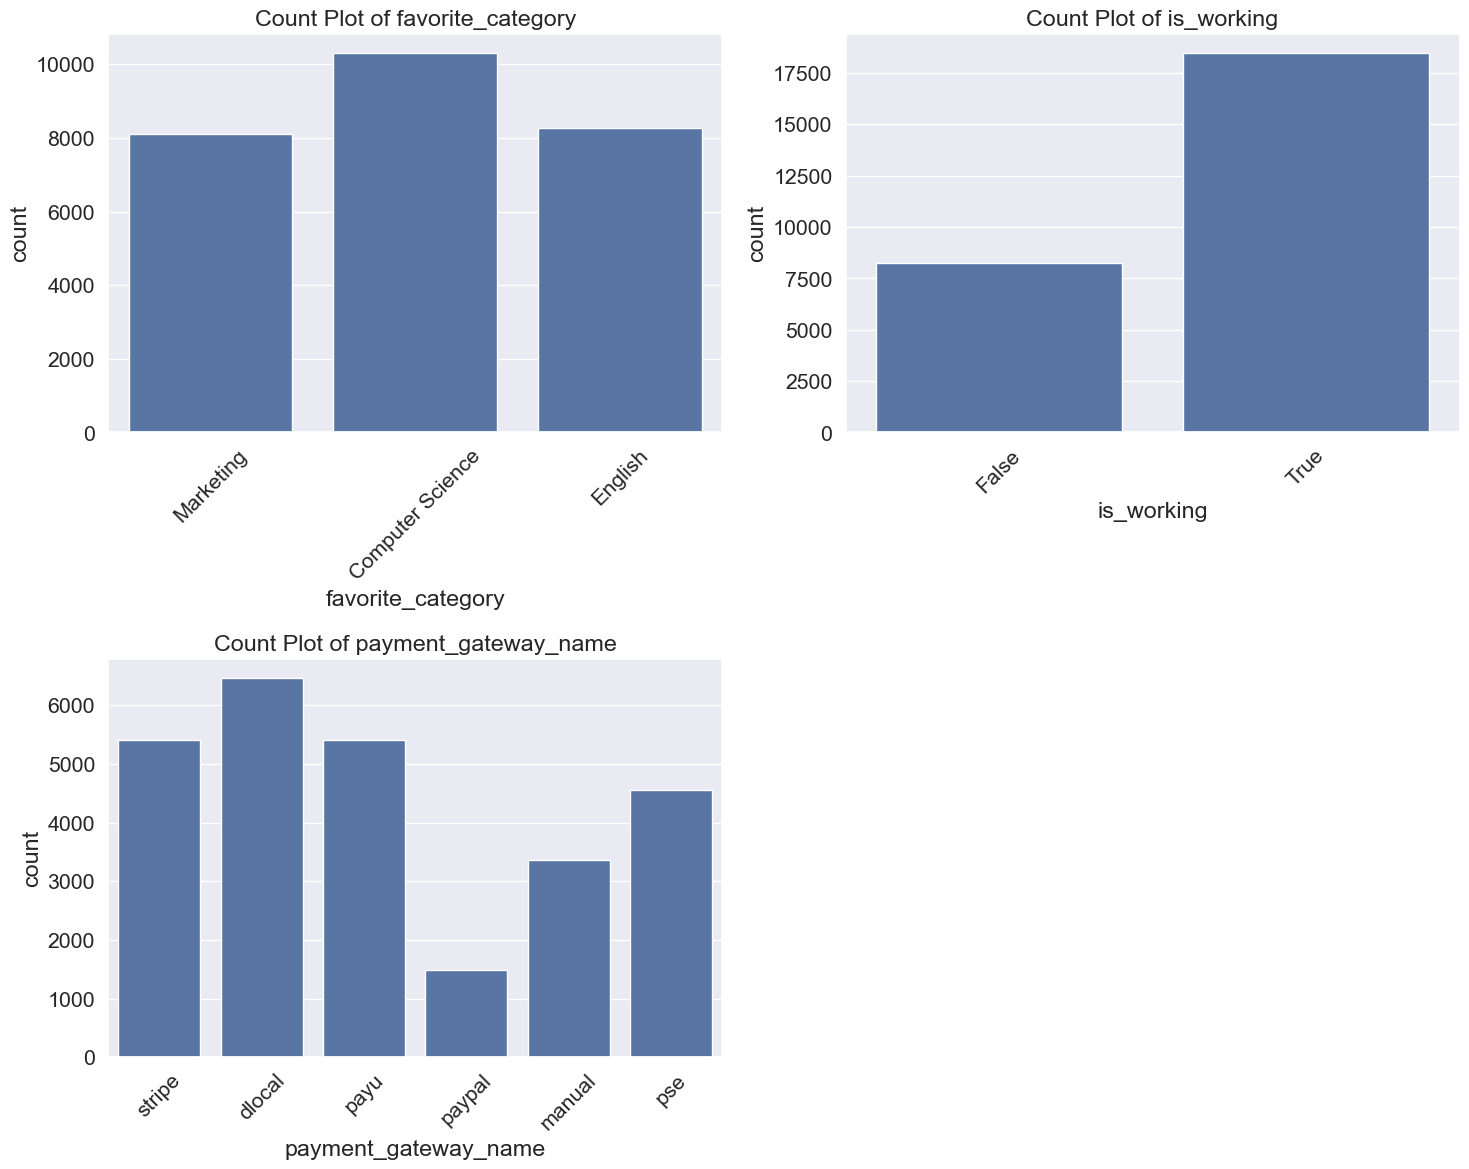

In [261]:
# Count plot of categorical variables
categorical_cols = ['favorite_category', 'is_working', 'payment_gateway_name']
plt.figure(figsize=(15, 12))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df4, x=col)
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

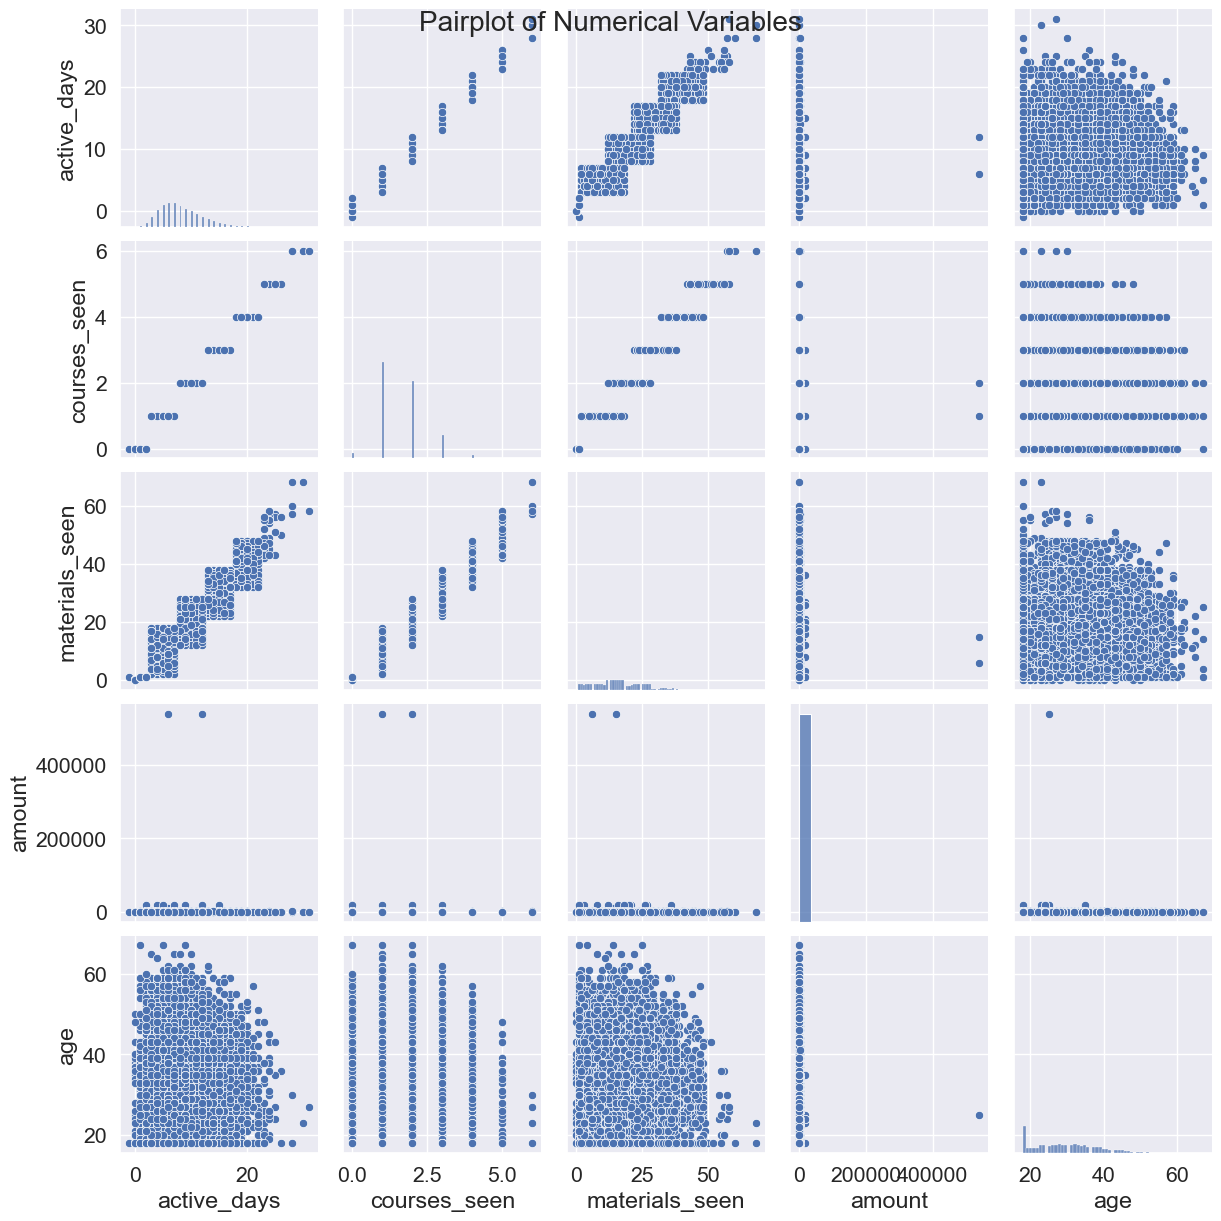

In [277]:
# Scatter plot of numerical variables against each other
plt.figure(figsize=(12, 8))
sns.pairplot(df4[['active_days', 'courses_seen', 'materials_seen', 'amount', 'age']])
plt.suptitle('Pairplot of Numerical Variables')
plt.show()

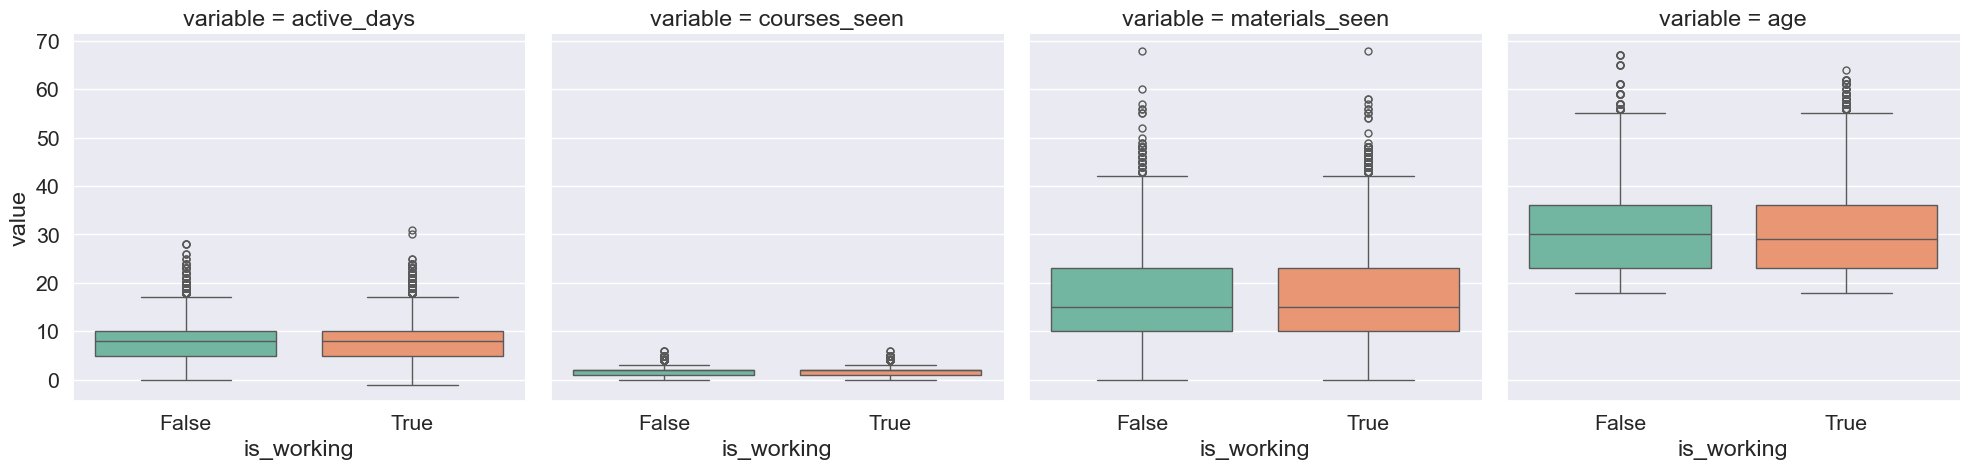

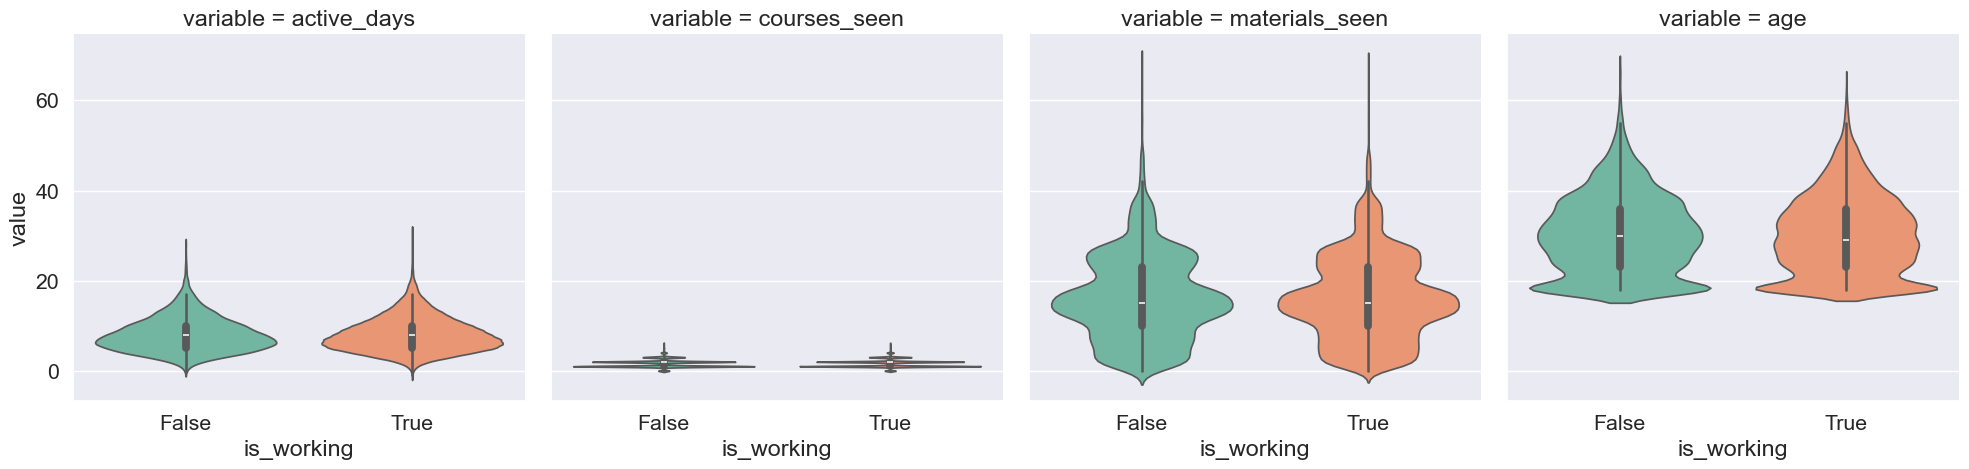

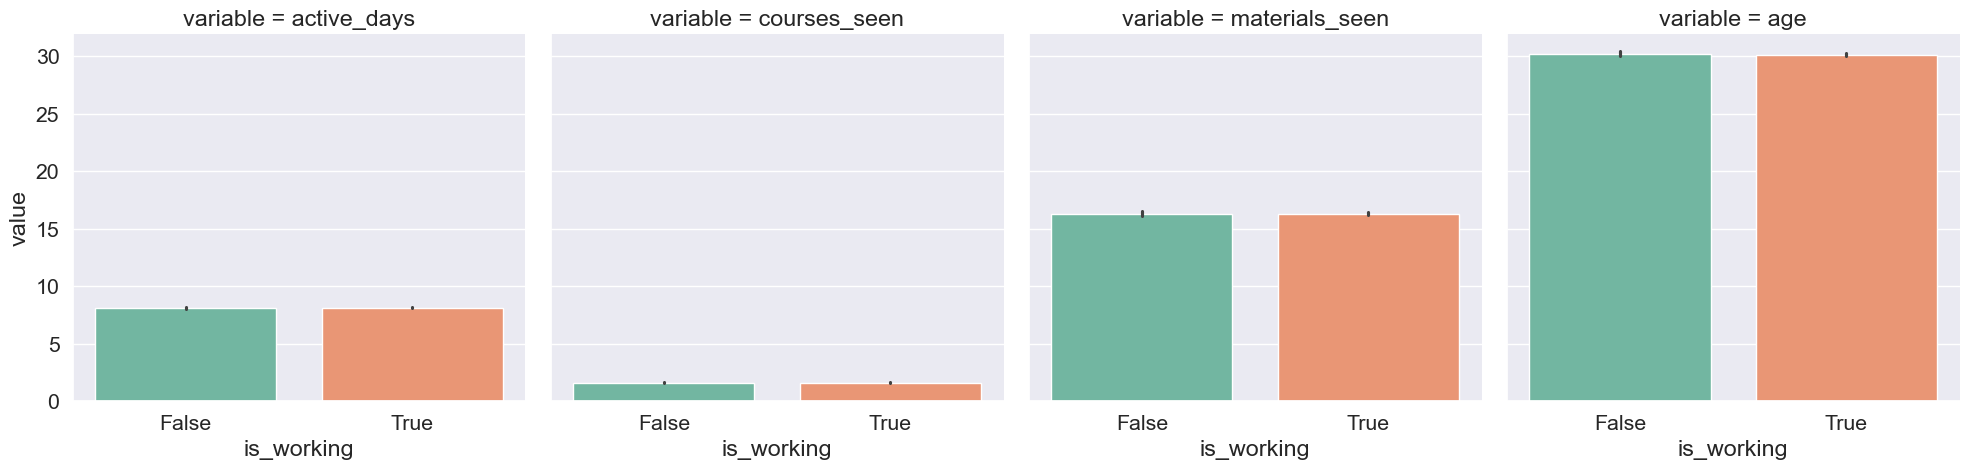

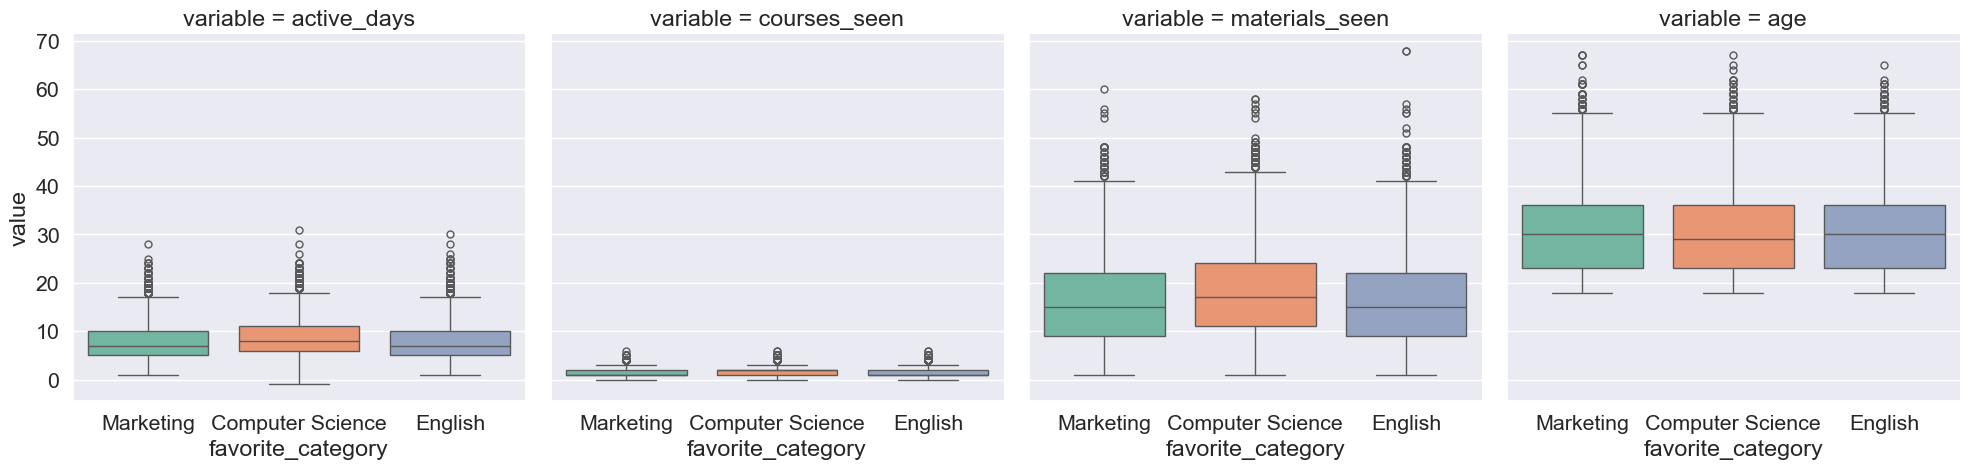

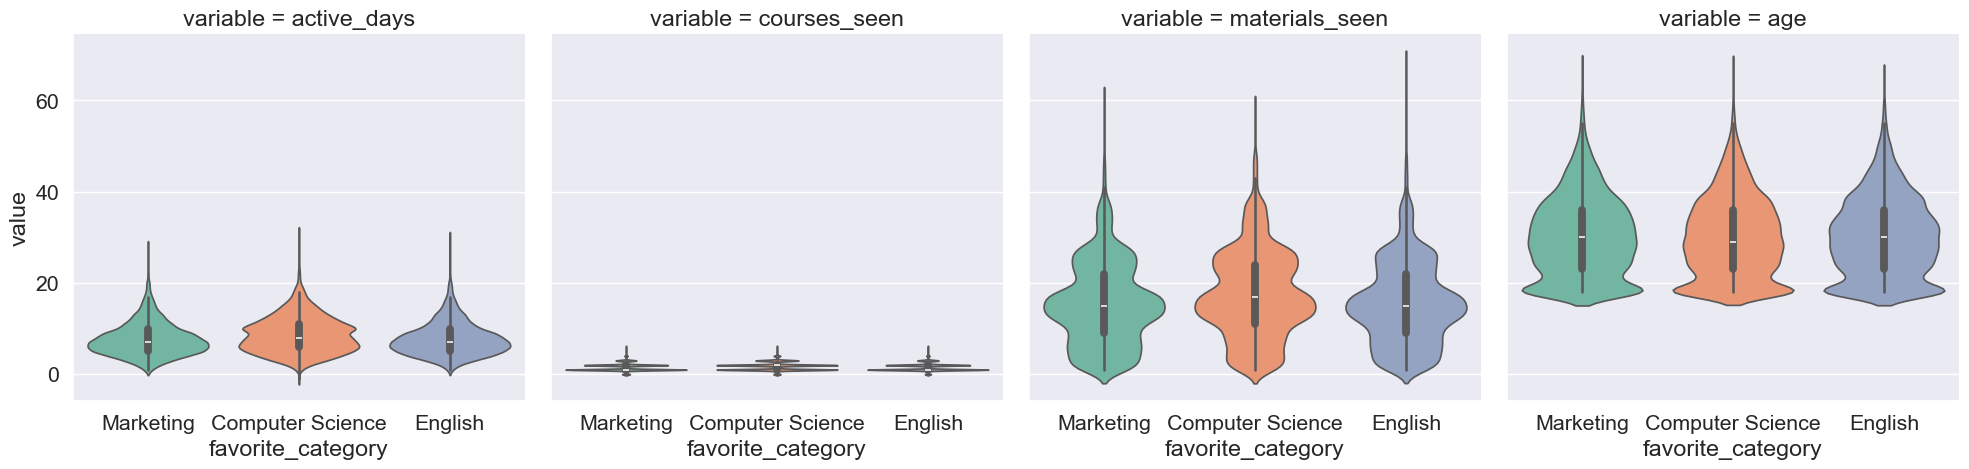

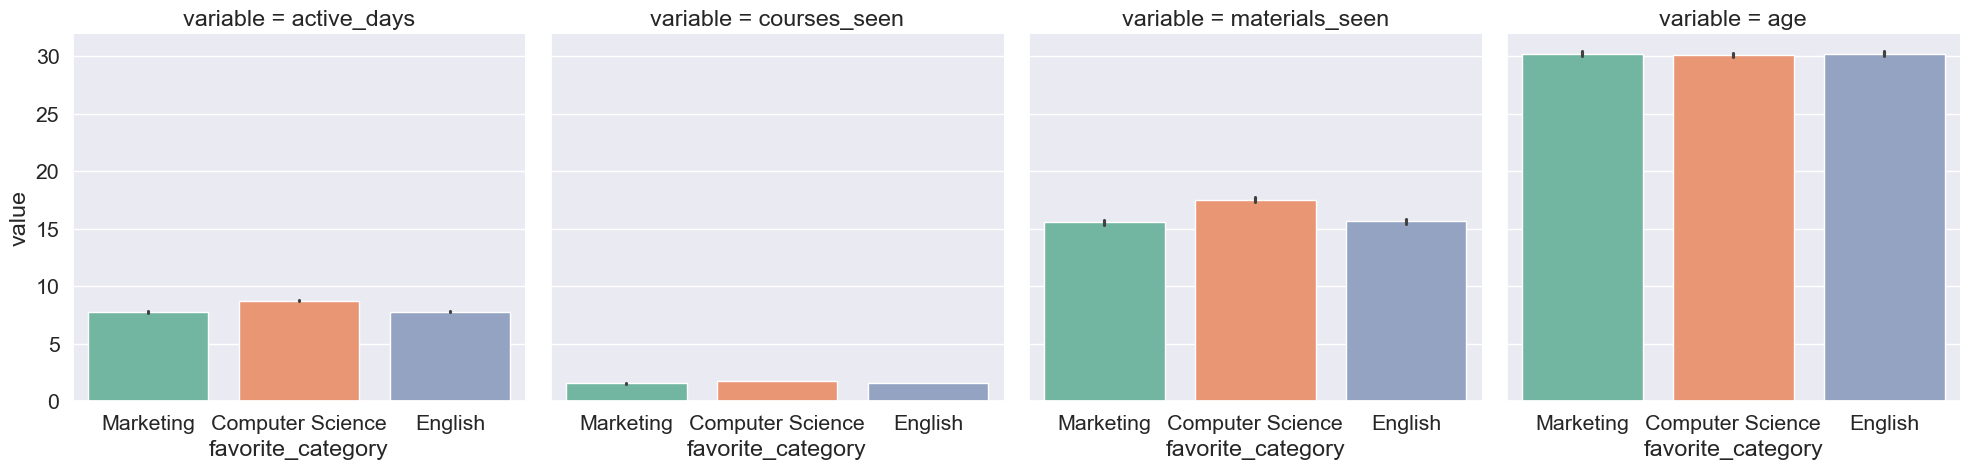

In [279]:
# categorical vs numericals
numerical_variables = ['active_days', 'courses_seen', 'materials_seen', 'age']
categorical_variables = ['is_working', 'favorite_category']

# Iterate over categorical variables
for cat_var in categorical_variables:
    sns.catplot(x=cat_var, y="value", col="variable", hue=cat_var, data=df4.melt(id_vars=cat_var, value_vars=numerical_variables), kind="box", palette="Set2",legend=False)
    sns.catplot(x=cat_var, y="value", col="variable", hue=cat_var, data=df4.melt(id_vars=cat_var, value_vars=numerical_variables), kind="violin", palette="Set2",legend=False)
    sns.catplot(x=cat_var, y="value", col="variable", hue=cat_var, data=df4.melt(id_vars=cat_var, value_vars=numerical_variables), kind="bar", palette="Set2",legend=False)

### 1.2 Strategies to Improve User Retention

#### Executive Summary:
The descriptive analysis has provided valuable insights into user behavior and preferences. Here, we present concrete strategies to enhance user retention.

#### Proposed Strategies:

- **Gamification to Foster Continuity:**
    - Implement a reward system based on continuous activity.
    - Example: Daily evolutionary experience unlocking benefits such as premium content or access to additional courses.

- **Content Variety:**
    - Develop micro and macro courses to cater to different levels of commitment and time availability.
    - Micro-courses for users with limited time, and macro-courses for those seeking a deeper focus.

- **Focus on Young Demography:**
    - Offer relevant content for the professional and personal growth of young users (20-30 years).
    - Incorporate innovative technologies and courses focused on market-demanded skills.

- **Subscriber Retention Programs:**
    - Establish progressive discount programs to encourage subscription renewals.
    - Offer cumulative discounts based on user engagement and activity.

- **Content and Payment Method Diversification:**
    - Expand course offerings in popular areas like Computer Science.
    - Explore alternative payment methods such as Nequi in Colombia and Oxxo payments in Mexico to improve accessibility.

- **Encouraging Interaction and Collaboration:**
    - Promote user interaction through challenges and collaborative projects.
    - Offer incentives such as free memberships for standout projects, stimulating participation and networking.

- **Additional Option: Challenges Among Friends and Leagues:**
    - Introduce challenges among friends, such as competing to generate the most experience points or excel in a specific project, to enhance user motivation.
    - Recognize top performers in leagues during live meetings and award them with certificates of achievement, fostering a sense of accomplishment and motivation.

#### Conclusions:
The proposed strategies, along with the additional option of challenges among friends and leagues, are designed to address key areas of opportunity identified in the analysis. By focusing on gamification, content diversification, and subscriber retention programs, we aim to significantly enhance user retention and strengthen our market position.


##### NOTE:
Maybe some of these strategies are already implemented like for example the payments in OXXO

# Machine learning Model - Churn Prediction

### We are going to approach the Churn Probability. Churn is consider after 1 month without paying a subscription or being active (end_date=paymant_date+active_days)

In [161]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score

In [162]:
df_model = df4.copy()

In [163]:
df_model.sort_values(by=['user_id', 'payment_date'], inplace=True)

# Calculate the time difference between consecutive payments
df_model['time_diff'] = df_model.groupby('user_id')['payment_date'].diff().dt.days

### Here we aggregated the info for customer, to get ready for the model

In [192]:
df_model2 = df_model.groupby(by=['user_id', 'payment_gateway_id']).agg(
    subscription_number=('subscription_number', np.max),
    active_days=('active_days', np.sum),
    courses_seen=('courses_seen', np.sum),
    materials_seen=('materials_seen', np.sum),
    amount=('amount', np.sum),
    end_date=('payment_date', np.max),
    start_date=('payment_date', np.min),
    mean_days_payments=('time_diff', np.mean),  # Calculate the mean of time differences
    age=('age', np.mean)
)#.reset_index()

### Define the variable of prediction

In [207]:
churn_date = df_model2.end_date.max() - pd.DateOffset(days=30)
print(churn_date)

# Create the target column, we assume churn is 2 months without payment
df_model2['churned'] = df_model2['end_date'] < churn_date
df_model2['churned'] = df_model2['churned'].astype(int)

2024-03-31 00:00:00


### Creation of Feature engineering & encoding

In [208]:
df_model2["longevity"] = (df_model2["end_date"] - df_model2["start_date"]).dt.days.astype('int64')
df_model2["mean_days_payments"] = df_model2["mean_days_payments"].fillna(0)

In [209]:
# Create one-hot encoding for 'favorite_category' and 'is_working'
one_hot_df = pd.get_dummies(df_model[['user_id', 'favorite_category', 'is_working']], columns=['favorite_category', 'is_working'])

# Aggregate one-hot encoded features
one_hot_features = one_hot_df.groupby('user_id').sum()

# Combine numerical and one-hot encoded features
grouped_df = pd.merge(df_model2, one_hot_features, on='user_id')

# Reset index to make user_id a column again
grouped_df.reset_index(inplace=True)

In [221]:
grouped_df.head()

,user_id,subscription_number,active_days,courses_seen,materials_seen,amount,end_date,start_date,mean_days_payments,age,churned,longevity,favorite_category_Computer Science,favorite_category_English,favorite_category_Marketing,is_working_False,is_working_True
0,1.0,2.229894,3.701534,3.684970,3.192265,-0.006655,2024-02-24,2023-07-24,1.119898,-0.697884,1,2.250923,2,2,3,0,7
1,2.0,1.374605,1.872100,1.913727,1.503466,-0.013592,2024-04-29,2023-11-29,0.769928,0.429576,0,1.367719,1,2,3,6,0
2,3.0,-0.763616,-0.922867,-0.869653,-0.657204,-0.017060,2023-06-11,2023-06-11,-1.188182,0.316830,1,-0.763185,0,0,1,0,1
3,4.0,2.229894,2.380276,2.166762,1.751819,-0.004920,2024-04-17,2023-09-17,0.771769,2.346259,0,2.222885,2,4,2,0,8
4,5.0,1.374605,1.211472,1.154624,1.677313,-0.013592,2024-04-10,2023-11-10,0.769928,1.218799,0,1.367719,2,2,2,0,6


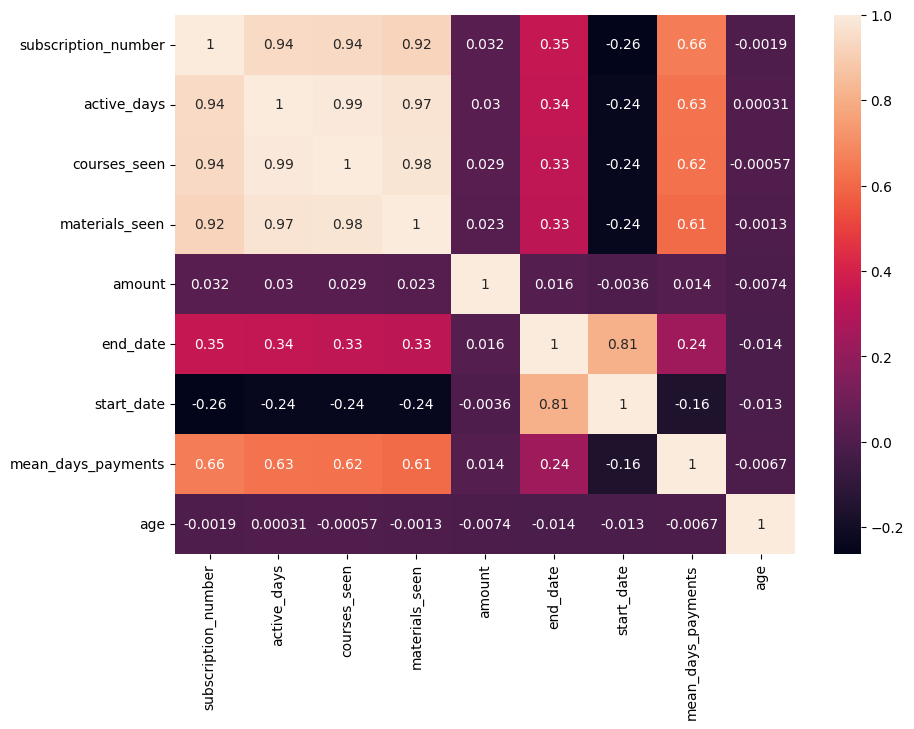

In [211]:
correlation = grouped_df.iloc[:,1:10].corr()
plt.figure(figsize=(10,7))
corr_map = sns.heatmap(correlation, annot=True)

In [222]:
grouped_df.columns

Index(['user_id', 'subscription_number', 'active_days', 'courses_seen',
       'materials_seen', 'amount', 'end_date', 'start_date',
       'mean_days_payments', 'age', 'churned', 'longevity',
       'favorite_category_Computer Science', 'favorite_category_English',
       'favorite_category_Marketing', 'is_working_False', 'is_working_True'],
      dtype='object')

### Scaling numerical features

In [213]:
numerical_features = ['subscription_number', 'active_days', 'courses_seen',
       'materials_seen', 'amount','mean_days_payments', 'age', 'longevity']

In [214]:
scaler = StandardScaler()
grouped_df[numerical_features] = scaler.fit_transform(grouped_df[numerical_features])

### Spliting X and y train and test

In [223]:
# Split data
X = grouped_df.drop(["user_id", 'end_date', 'start_date','churned','age','materials_seen'], axis=1)
y = grouped_df["churned"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Running the model

In [ ]:
# Model training (Logistic Regression)
model = LogisticRegression()
model.fit(X_train, y_train)

# Model evaluation
y_pred = model.predict(X_test)

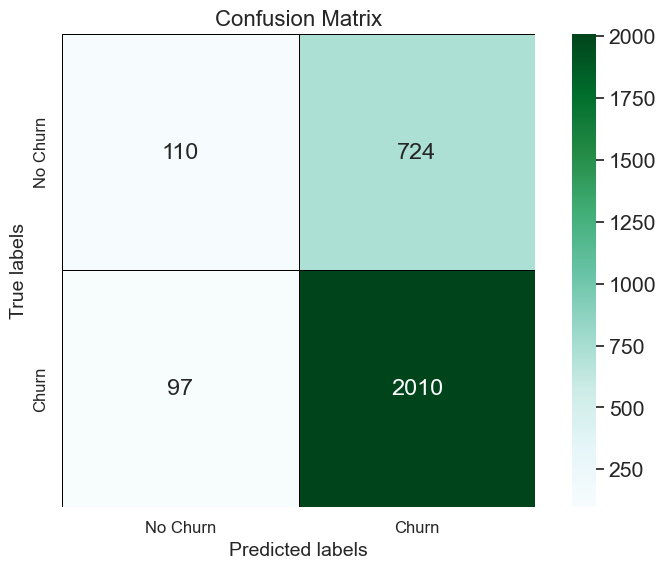

In [235]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  
sns.heatmap(cm, annot=True, fmt="d", cmap="BuGn", cbar=True, square=True, linewidths=0.5, linecolor='black')  
plt.xlabel('Predicted labels', fontsize=14)  
plt.ylabel('True labels', fontsize=14)  
plt.title('Confusion Matrix', fontsize=16) 
plt.xticks(ticks=np.arange(2) + 0.5, labels=['No Churn', 'Churn'], fontsize=12)  
plt.yticks(ticks=np.arange(2) + 0.5, labels=['No Churn', 'Churn'], fontsize=12)  

plt.tight_layout()  
plt.show()

In [236]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nModel Evaluation:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Model Evaluation:
Accuracy: 0.7208432505950357
Precision: 0.7351865398683248
Recall: 0.9539629805410537
F1-score: 0.8304069407147283


## Linear Regression Analysis Results

After conducting a linear regression analysis, we were able to obtain these results:

- **Accuracy:** Approximately 72%
  
From the machine learning model, we can conclude that we achieved a decent accuracy. This suggests that we could make reasonably good predictions regarding the likelihood of churn.

### Study Focus

For this study, we primarily focused on numerical variables that contributed value. Factors such as courses taken or the age of our clients were discarded. Additionally, we excluded the payment dates variable as it was indirectly associated with start and end dates, and correlated with the number of subscriptions. Including it might have led to overfitting without adding significant value.

### Recommendations for Future Studies

It's recommended to incorporate additional descriptive variables and behavioral metrics, such as:
- Time spent on each course
- Number of exams passed per course
- Monthly study hours
- Number of users by account
- User engagement

Moreover, considering aspects like profession, region, and whether the user is studying independently or through a university could further enhance the model.


# SQL VIEW
To be honest I have done some SQL DB but is not my main skill, however I use SQL for analytics everyday, so I found this way to show you a little bit of my SQL knowledge

In [282]:
from sqlalchemy import create_engine

In [283]:
# Create SQLAlchemy engine
engine = create_engine('sqlite:///:memory:')

In [284]:
# Store DataFrames in the SQLite database
df_users.to_sql('users', engine)
df_payments.to_sql('payments', engine)
df_payments_gateaways.to_sql('payments_gateaways', engine)
df_engagment.to_sql('engagment', engine)

28202

In [285]:
df4.columns

Index(['user_id', 'subscription_id', 'active_days', 'courses_seen',
       'materials_seen', 'favorite_category', 'email', 'amount',
       'payment_date', 'payment_gateway_id', 'subscription_number',
       'first_name', 'age', 'is_working', 'payment_gateway_name', 'end_date'],
      dtype='object')

In [301]:
# Querying using SQL
query = """
SELECT 
    favorite_category,
    COUNT(DISTINCT u.user_id) AS users
    
FROM engagment e
INNER JOIN payments p ON p.subscription_id = e.subscription_id
INNER JOIN users u ON u.user_id = e.user_id AND p.email = u.email

WHERE e.user_id IS NOT NULL
 AND p.email IS NOT NULL

GROUP BY 1
ORDER BY 2 DESC
"""

In [303]:
result = pd.read_sql_query(query, engine)
print("SQL to look for the TOP category")
result

SQL to look for the TOP category


,favorite_category,users
0,Computer Science,6163
1,English,5042
2,Marketing,5015
3,None,38


In [314]:
# Querying using SQL
query = """
SELECT 
    u.user_id,
    u.first_name,
    u.email,
    MAX(subscription_number) AS last_subscription
FROM engagment e
INNER JOIN payments p ON p.subscription_id = e.subscription_id
INNER JOIN users u ON u.user_id = e.user_id AND p.email = u.email

WHERE e.user_id IS NOT NULL
 AND p.email IS NOT NULL
GROUP BY 1,2
HAVING last_subscription > 5
"""

In [315]:
result = pd.read_sql_query(query, engine)
print("SQL to look for customers with more than 5 subscriptions")
result

SQL to look for the TOP category


,user_id,first_name,email,last_subscription
0,1.0,Katie,mary60@assessment.com,8
1,2.0,Karen,tonya73@assessment.com,6
2,4.0,Mike,david97@assessment.com,8
3,5.0,Michelle,michelle41@assessment.com,6
4,15.0,Jessica,eric13@assessment.com,6
...,...,...,...,...
1214,9956.0,Todd,jonathan54@assessment.com,6
1215,9959.0,Kyle,robert44@assessment.com,9
1216,9962.0,Jill,annette53@assessment.com,11
1217,9971.0,Sean,scott3@assessment.com,8


In [335]:
# Querying using SQL
query = """
SELECT 
    pn.payment_gateway_name,
    u.is_working,
    COUNT(e.subscription_id) AS subscriptions

FROM engagment e
INNER JOIN payments p ON p.subscription_id = e.subscription_id
INNER JOIN users u ON u.user_id = e.user_id AND p.email = u.email
INNER JOIN payments_gateaways pn ON p.payment_gateway_id = pn.payment_gateway_id

WHERE e.user_id IS NOT NULL
 AND p.email IS NOT NULL

GROUP BY 1,2
ORDER BY 1 DESC,3 DESC,2 ASC
"""

In [336]:
result = pd.read_sql_query(query, engine)
print("SQL to look for distribution of subscriptions for payment method and working status")
result

SQL to look for customers with more than 5 subscriptions


,payment_gateway_name,is_working,subscriptions
0,stripe,1,3720
1,stripe,0,1550
2,pse,1,3240
3,pse,0,1212
4,payu,1,3617
5,payu,0,1609
6,paypal,1,898
7,paypal,0,585
8,manual,1,1820
9,manual,0,1085


In [376]:
# Querying using SQL
query = """
SELECT 
    strftime('%Y-%m', p.payment_date) AS month,
    e.favorite_category,
    SUM(e.active_days) AS month_active_days
    
FROM engagment e
INNER JOIN payments p ON p.subscription_id = e.subscription_id
INNER JOIN users u ON u.user_id = e.user_id AND p.email = u.email
INNER JOIN payments_gateaways pn ON p.payment_gateway_id = pn.payment_gateway_id

WHERE e.user_id IS NOT NULL
 AND p.email IS NOT NULL

GROUP BY 1,2
ORDER BY 1,3 DESC,2
"""

In [378]:
result = pd.read_sql_query(query, engine)
print("SQL to look the trend month by month of the active days")
result

SQL to look the trend month by month of the active days


,month,favorite_category,month_active_days
0,2023-04,Computer Science,3487
1,2023-04,English,1284
2,2023-04,Marketing,1264
3,2023-04,None,0
4,2023-05,Computer Science,4795
5,2023-05,English,2737
6,2023-05,Marketing,2448
7,2023-05,None,0
8,2023-06,Computer Science,5451
9,2023-06,English,3529
